In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [43]:
fight_data = pd.read_csv('Cleaned Dataset/cleaned_ufc_fight_data.csv')
fight_stat_data = pd.read_csv('Cleaned Dataset/cleaned_ufc_fight_stat_data.csv')
fighter_data = pd.read_csv('Cleaned Dataset/cleaned_ufc_fighter_data.csv')
event_data = pd.read_csv('Cleaned Dataset/cleaned_ufc_event_data.csv')

# Data Analysis

### Knockdowns vs. Win Ratios

Goal: Look at the relationship between the number of knockdowns and the likeliood of winning the fight.

1. Step 1: Data Prep:
    - Filter rows that have non-null values for knowndowns and fighter_id in fight_stat_data
    - Merge filtered fight_stat_data with fight_data to get info about which fighter won for each fight (winner) 
    
2. Step 2: Calculate KD and Win outcome:
    - Group merged data by fighter_id
    - Calculate total number of KD and total number of wins for each fighter.
    - Calculate how many fights each fighter won, (fighter_id, winner, fight_data) 
    
3. Step 3: Calculate win ratios: 
    - total wins / total fights
    - Seperate fighters into categories based on KD 
    - Get the average win ratio for each KD category

4. Visualization:
    - Create a bar chart to comapre the average win ratio for each KD category
    
5. Insights:
    - Anayse the graph to see if there is a trend between KD and win ratios.
    - See if the differences are statistically significant (maybe chi-sqauare test)

In [30]:
filtered_stats = fight_stat_data.dropna(subset=['knockdowns', 'fighter_id'])

In [31]:
merged_data = filtered_stats.merge(fight_data, how='left', left_on='fight_id', right_on='fight_id')

### Knockdowns and Win Outcome

In [32]:
merged_data['is_winner'] = merged_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)
grouped_data = merged_data.groupby('fighter_id').agg(
    total_knockdowns=('knockdowns', 'sum'),
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [33]:
grouped_data['win_ratio'] = grouped_data['total_wins'] / grouped_data['total_fights']

In [34]:
knockdown_bins = [0, 1, 3, float('inf')]
knockdown_labels = ['0-1', '2-3', '4+']
grouped_data['knockdown_category'] = pd.cut(grouped_data['total_knockdowns'], bins=knockdown_bins, labels=knockdown_labels)

In [35]:
grouped_data['win_ratio'] = grouped_data['total_wins'] / grouped_data['total_fights']


In [36]:
knockdown_bins = [0, 1, 3, float('inf')]
knockdown_labels = ['0-1', '2-3', '4+']
grouped_data['knockdown_category'] = pd.cut(grouped_data['total_knockdowns'], bins=knockdown_bins, labels=knockdown_labels)

In [37]:
knockdown_vs_win_ratio = grouped_data.groupby('knockdown_category')['win_ratio'].mean().reset_index()

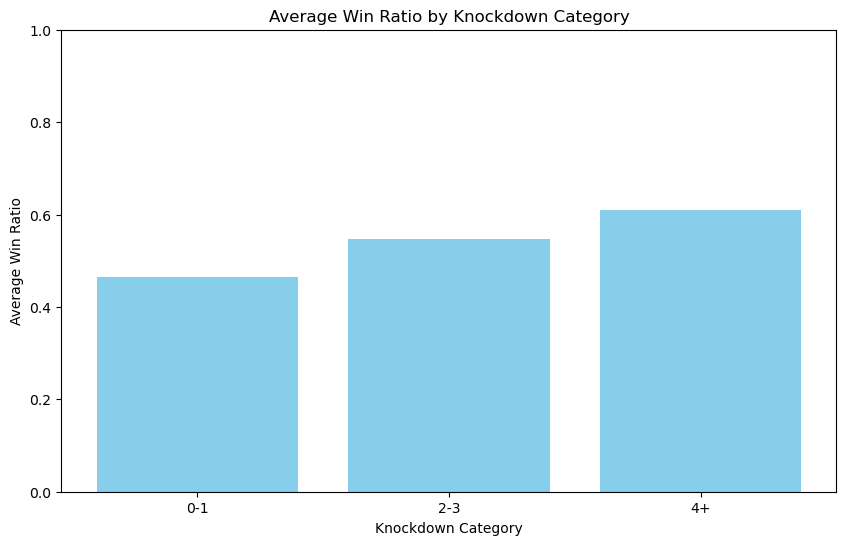

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(knockdown_vs_win_ratio['knockdown_category'], knockdown_vs_win_ratio['win_ratio'], color='skyblue')
plt.xlabel('Knockdown Category')
plt.ylabel('Average Win Ratio')
plt.title('Average Win Ratio by Knockdown Category')
plt.ylim(0, 1)
plt.show()

In [39]:
contingency_table = pd.crosstab(grouped_data['knockdown_category'], grouped_data['total_wins'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [40]:
print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

Chi-square test statistic: 453.7118406358914
P-value: 1.9664049913851846e-67


### Insights: 

**Knockdowns as a Success Predictor:** As evidenced by the much greater success rates of fighters with more knockdowns, especially 4+, knockdowns are a powerful predictor of battle outcomes.

**Strategic Implications:** Prioritizing strategies that increase knockdown potential may be advantageous given the strong association between winning and knockdowns.

**Statistical Significance:** With a relatively low p-value, the chi-square test result shows that the observed variations in victory ratios between knockdown categories are statistically significant. This supports the idea that knockdowns have a significant impact on winning since it indicates that the correlation between knockdowns and win rates is unlikely to be the result of chance.

Given that boxers with four or more knockdowns have notably greater victory rates, the threshold effect identifies a point at which knockdowns may signify dominant performance.






### How do fight outcomes differ based on stances like Orthodox, Southpaw, and Switch?  

1. Merge relevant data from the datatsets
2. Aggregate data by stance
3. Visualize

In [44]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')

In [45]:
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)


In [46]:
stance_analysis = full_data.groupby('fighter_stance').agg(
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [47]:
stance_analysis['win_ratio'] = stance_analysis['total_wins'] / stance_analysis['total_fights']


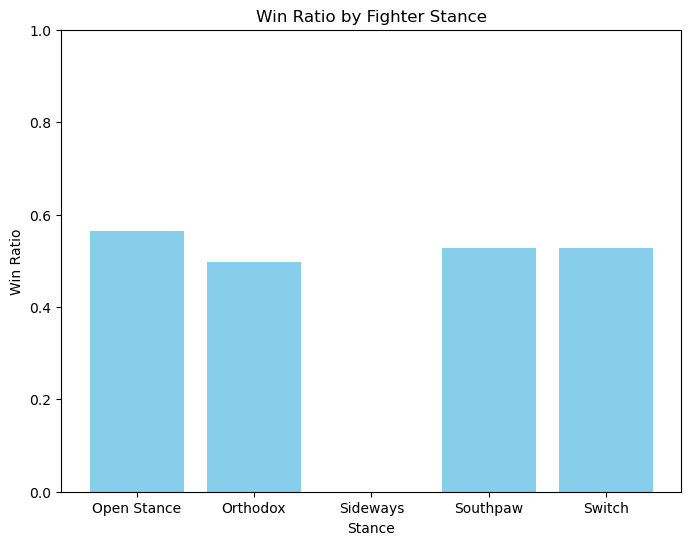

In [48]:
plt.figure(figsize=(8, 6))
plt.bar(stance_analysis['fighter_stance'], stance_analysis['win_ratio'], color='skyblue')
plt.xlabel('Stance')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Fighter Stance')
plt.ylim(0, 1)
plt.show()

In [49]:
print(stance_analysis)

  fighter_stance  total_fights  total_wins  win_ratio
0    Open Stance            23          13   0.565217
1       Orthodox         10555        5252   0.497584
2       Sideways             1           0   0.000000
3       Southpaw          2780        1468   0.528058
4         Switch           673         355   0.527489


### Insights: 

According to the data, fighters who adopt the Southpaw and Switch stances had somewhat greater victory percentages than Orthodox fighters, which may indicate that these less popular stances provide a tactical edge. Despite being the most common viewpoint, orthodoxy has a lower success percentage, maybe because it is predictable. Though less frequent, the Open Stance also has a comparatively high victory rate. This implies that different stances could affect how a battle turns out, providing fighters who want to improve their performance by changing their stance some knowledge.


### What impact does age have on a fighter’s success, especially comparing fighters under 20 vs. over 20?  

1. Classify fighters into age groups
2. Calculate win ratios
3. Visualize

In [50]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')


In [51]:
full_data['fighter_dob'] = pd.to_datetime(full_data['fighter_dob'], errors='coerce')
full_data['event_date'] = pd.to_datetime(full_data['event_date'], errors='coerce')


In [52]:
full_data['age_at_fight'] = (full_data['event_date'] - full_data['fighter_dob']).dt.days / 365.25

full_data['age_group'] = full_data['age_at_fight'].apply(lambda x: 'Under 20' if x < 20 else 'Over 20')
full_data['is_winner'] = full_data.apply(lambda row: 1 if row['fighter_id'] == row['winner'] else 0, axis=1)


In [53]:
age_analysis = full_data.groupby('age_group').agg(
    total_fights=('fight_id', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()


In [54]:
age_analysis['win_ratio'] = age_analysis['total_wins'] / age_analysis['total_fights']


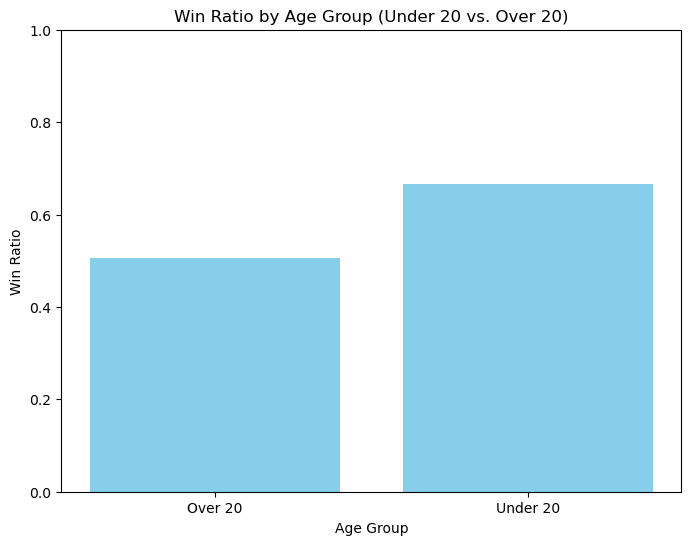

In [55]:
plt.figure(figsize=(8, 6))
plt.bar(age_analysis['age_group'], age_analysis['win_ratio'], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Age Group (Under 20 vs. Over 20)')
plt.ylim(0, 1)
plt.show()

In [56]:
print(age_analysis)

  age_group  total_fights  total_wins  win_ratio
0   Over 20         14020        7080   0.504993
1  Under 20            12           8   0.666667


### Insights: 

Although the sample size for fighters under 20 is much less, the research reveals that their victory ratio is greater (66.7%) than that of fighters over 20 (50.5%). This implies that although younger competitors could have an advantage, conclusions should be read cautiously because there is little data for under-20 combatants. This data could suggest that younger combatants have an edge in agility or resilience, but more research with a bigger sample size would be helpful.


### How do strike patterns differ across various weight divisions and genders?

1. Classify Strikes (attempted and successful)
2. Calculate average strike accuracy
3. Visualize

In [57]:
merged_data = fight_stat_data.merge(fight_data, how='left', on='fight_id')
full_data = merged_data.merge(fighter_data, how='left', on='fighter_id')
full_data = full_data.merge(event_data[['event_id', 'event_date']], how='left', on='event_id')

In [58]:
full_data['total_strike_accuracy'] = full_data['total_strikes_succ'] / full_data['total_strikes_att']
full_data['sig_strike_accuracy'] = full_data['sig_strikes_succ'] / full_data['sig_strikes_att']

In [59]:
strike_analysis = full_data.groupby(['weight_class', 'gender']).agg(
    avg_total_strike_accuracy=('total_strike_accuracy', 'mean'),
    avg_sig_strike_accuracy=('sig_strike_accuracy', 'mean')
).reset_index()

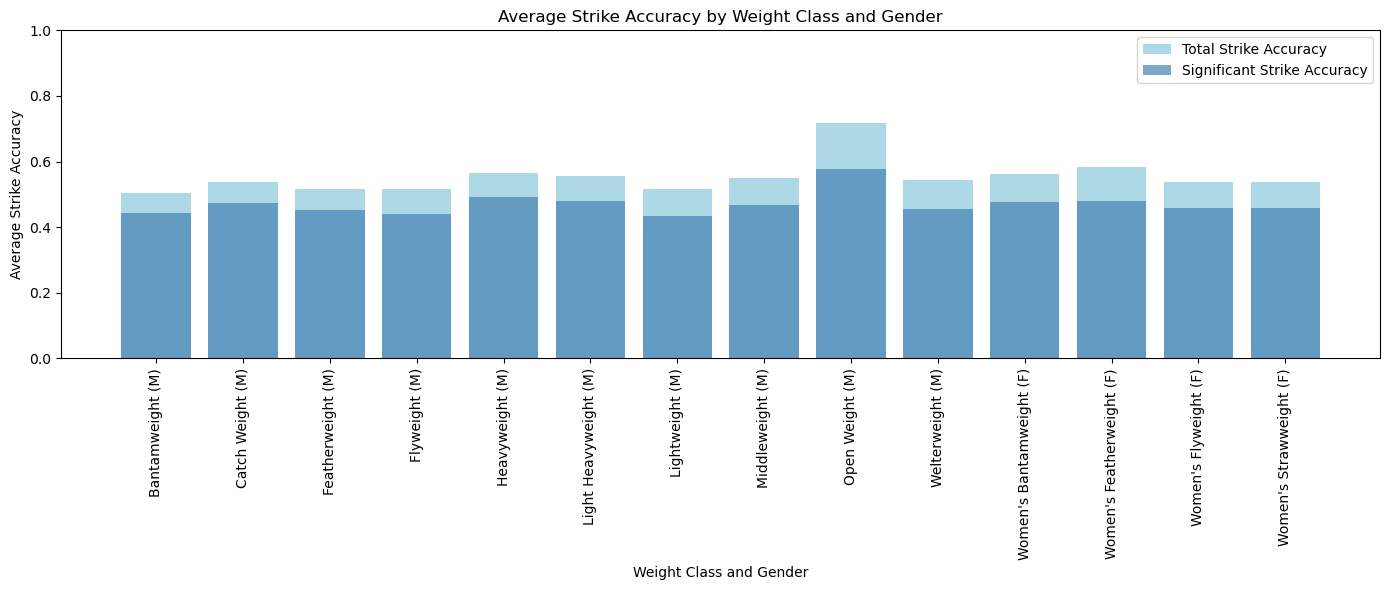

In [60]:
plt.figure(figsize=(14, 6))
plt.bar(strike_analysis['weight_class'] + ' (' + strike_analysis['gender'] + ')', 
        strike_analysis['avg_total_strike_accuracy'], color='lightblue', label='Total Strike Accuracy')
plt.bar(strike_analysis['weight_class'] + ' (' + strike_analysis['gender'] + ')', 
        strike_analysis['avg_sig_strike_accuracy'], color='steelblue', alpha=0.7, label='Significant Strike Accuracy')

plt.xlabel('Weight Class and Gender')
plt.ylabel('Average Strike Accuracy')
plt.title('Average Strike Accuracy by Weight Class and Gender')
plt.xticks(rotation=90)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [61]:
print(strike_analysis)

             weight_class gender  avg_total_strike_accuracy  \
0            Bantamweight      M                   0.504518   
1            Catch Weight      M                   0.537489   
2           Featherweight      M                   0.515902   
3               Flyweight      M                   0.516661   
4             Heavyweight      M                   0.563712   
5       Light Heavyweight      M                   0.554698   
6             Lightweight      M                   0.515309   
7            Middleweight      M                   0.549846   
8             Open Weight      M                   0.717306   
9            Welterweight      M                   0.542491   
10   Women's Bantamweight      F                   0.561209   
11  Women's Featherweight      F                   0.582252   
12      Women's Flyweight      F                   0.536276   
13    Women's Strawweight      F                   0.536282   

    avg_sig_strike_accuracy  
0                  0.444

### Insights

The current research points out a large discrepancy in the striking accuracy with regard to both gender and weight class. Male fighters appear to do better in heavier weight classes, such as Heavyweight and Light Heavyweight, while females perform somewhat better in lighter weight classes, such as Women's Featherweight. Interestingly enough, total accuracy was the highest among them all in the odd Open Weight class. Since the fact remains that larger divisions and some of the women's weight classes do stick out for their preciseness, it goes to show that gender and weight class could affect striking success.
